In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, use_bn = False):
        super().__init__()
        self.use_bn = use_bn
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(in_channels)    
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required

    def forward(self, x):
        residual = x
        out = x
        if self.use_bn:
            out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += residual
        return out

class ResidualPipeline(nn.Module):
    def __init__(self, in_channels, n_units, use_bn = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1, bias=True)
        layers = []
        for i in range(n_units):
            layers.append(ResidualUnit(64, use_bn))
        self.resnet_stack = nn.Sequential(*layers)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_stack(x)
        x = self.relu(x) # not there in original paper
        x = self.conv2(x)
        return x
    
class STResnet(nn.Module):
    def __init__(self, c_channel, p_channel, t_channel, n_residual_units, map_dim, use_bn = False):
        super().__init__()
        self.c_pipe = ResidualPipeline(c_channel, n_residual_units, use_bn)
        self.p_pipe = ResidualPipeline(p_channel, n_residual_units, use_bn)
        self.t_pipe = ResidualPipeline(t_channel, n_residual_units, use_bn)
        # 1 dimension for batch processing, this class cannot process unbatched data
        self.w_c = nn.Parameter(torch.randn(1, *map_dim))
        self.w_p = nn.Parameter(torch.randn(1, *map_dim))
        self.w_t = nn.Parameter(torch.randn(1, *map_dim))
        self.tanh = nn.Tanh()
        
    def forward(self, x_c, x_p, x_t):
        y_c = self.c_pipe(x_c)
        y_p = self.p_pipe(x_p)
        y_t = self.t_pipe(x_t)
        # Fusion: Eliment wise product (Hadamard Product)
        y = self.w_c*y_c + self.w_p*y_p + self.w_t*y_t
        y = self.tanh(y)
        return y

In [3]:
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from BikeNYC import BikeNYCDataset
n_closeness = 4
n_period = 1
n_trend = 1
flow_ch = 2 # Inflow and Outflow
n_residual_units = 4
map_dim = (flow_ch, 21,12) # Specific to dataset
bikenyc_dataset_train = BikeNYCDataset('./Datasets/BikeNYC/flow_data.npy',n_closeness,n_period,n_trend,0.8,True)
bikenyc_dataset_test = BikeNYCDataset('./Datasets/BikeNYC/flow_data.npy',n_closeness,n_period,n_trend,0.8,False)

min: 0.0 max: 737.0
torch.Size([3379, 8, 21, 12]) torch.Size([3379, 2, 21, 12]) torch.Size([3379, 2, 21, 12])
min: 0.0 max: 737.0
torch.Size([845, 8, 21, 12]) torch.Size([845, 2, 21, 12]) torch.Size([845, 2, 21, 12])


In [4]:
from tqdm import tqdm
mmn = bikenyc_dataset_train.mmn

def train_epoch(model,dataloader,loss_fn,optimizer):
    train_loss = 0.0
    model.train()
    n_batches = 0
    for x_c, x_p, x_t, y in tqdm(dataloader):
        optimizer.zero_grad()
        output = model(x_c, x_p, x_t)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        n_batches += 1
    return train_loss/n_batches
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss = 0.0
    model.eval()
    n_batches = 0
    for x_c, x_p, x_t, y in dataloader:
        output = model(x_c, x_p, x_t)
        loss = loss_fn(output, y)
        valid_loss += loss.item()
        n_batches += 1
    return valid_loss/n_batches

In [5]:
import torch.optim as optim
batch_size = 32
num_epochs = 10
train_size = int(0.9 * len(bikenyc_dataset_train))
valid_size = len(bikenyc_dataset_train) - train_size

train_idx, valid_idx = random_split(range(len(bikenyc_dataset_train)), [train_size, valid_size])
train_loader = DataLoader(bikenyc_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(bikenyc_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

model = STResnet(n_closeness*flow_ch,n_period*flow_ch,n_trend*flow_ch,n_residual_units,map_dim,True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

history = {'train_loss': [], 'valid_loss': []}
for epoch in range(num_epochs):
    train_loss=train_epoch(model,train_loader,loss_fun,optimizer)
    valid_loss=valid_epoch(model,valid_loader,loss_fun)
    print("Epoch:{}/{} | Training Loss: {} | Validation Loss: {}".format(epoch + 1, num_epochs, train_loss, valid_loss))
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)

# from sklearn.model_selection import KFold
# splits = KFold(n_splits=10,shuffle=True)
# foldperf={}
# for fold, (train_idx,valid_idx) in enumerate(splits.split(np.arange(len(bikenyc_dataset_train)))):
#     print('Fold {}'.format(fold + 1))
#     # Train here
#     foldperf['fold{}'.format(fold+1)] = history  
#     torch.save(model,'checkpoints/stresnet.pt')    

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:08<00:00, 11.27it/s]


Epoch:1/10 | Training Loss: 0.09689942189288558 | Validation Loss: 0.003062387505038218


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.07it/s]


Epoch:2/10 | Training Loss: 0.0019116611820209073 | Validation Loss: 0.0015835242070765657


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.13it/s]


Epoch:3/10 | Training Loss: 0.00114638856939564 | Validation Loss: 0.001263147526928647


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.53it/s]


Epoch:4/10 | Training Loss: 0.0008821542596706422 | Validation Loss: 0.0009918091871606355


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.27it/s]


Epoch:5/10 | Training Loss: 0.0007703342574435131 | Validation Loss: 0.0011952746003358202


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.61it/s]


Epoch:6/10 | Training Loss: 0.0007251229611332141 | Validation Loss: 0.0011448346776887774


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.10it/s]


Epoch:7/10 | Training Loss: 0.0005918250568962927 | Validation Loss: 0.0007384794245643371


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.83it/s]


Epoch:8/10 | Training Loss: 0.0005458858183070939 | Validation Loss: 0.0008069067156280984


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.94it/s]


Epoch:9/10 | Training Loss: 0.0005182184828906126 | Validation Loss: 0.0006220475320746614


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.39it/s]


Epoch:10/10 | Training Loss: 0.00048046972369775176 | Validation Loss: 0.000579092812999575


In [42]:
import math
test_loader = DataLoader(bikenyc_dataset_test, batch_size=batch_size)
test_loss = 0.0
model.eval()
n_batches = 0
for x_c, x_p, x_t, y in test_loader:
    output = mmn.inverse_transform(model(x_c, x_p, x_t))
    loss = loss_fun(output, mmn.inverse_transform(y))
    test_loss += loss.item()
    n_batches += 1
rmse_loss = math.sqrt(test_loss/n_batches)
print(rmse_loss)
# torch.save(model.state_dict(), 'checkpoints/stresnet_9p3.pt')

9.375886761205866


In [44]:
flow_pred = np.zeros((len(bikenyc_dataset_test),*map_dim))
flow_org = np.zeros((len(bikenyc_dataset_test),*map_dim))
for i in range(len(bikenyc_dataset_test)):
    x_c, x_p, x_t, y = bikenyc_dataset_test[i]
    x_c = torch.unsqueeze(x_c, 0)
    x_p = torch.unsqueeze(x_p, 0)
    x_t = torch.unsqueeze(x_t, 0)    
    y_pred = model(x_c, x_p, x_t)
    flow_org[i,:,:,:] = mmn.inverse_transform(y).cpu().detach().numpy()[:,:,:]
    flow_pred[i,:,:,:] = mmn.inverse_transform(y_pred).cpu().detach().numpy()[:,:,:]

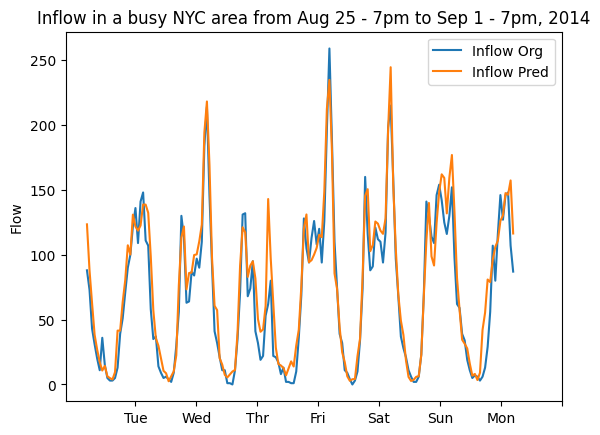

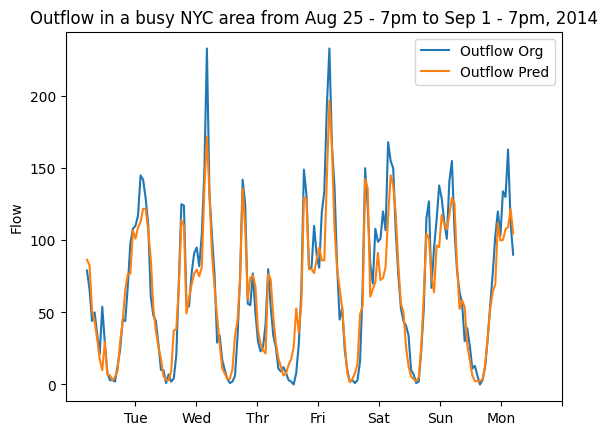

In [64]:
import matplotlib.pyplot as plt
x, y = 10, 3

fig = plt.figure()
in_flow_org = flow_org[24*7*0:24*7*1,0,x,y]
in_flow_pred = flow_pred[24*7*0:24*7*1,0,x,y]
t = np.linspace(1, 24*7*1, num=24*7*1)
plt.plot(t,in_flow_org,label='Inflow Org')
plt.plot(t,in_flow_pred,label='Inflow Pred')
plt.xticks(np.linspace(1+19, 168+19, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
plt.title('Inflow in a busy NYC area from Aug 25 - 7pm to Sep 1 - 7pm, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure()
out_flow_org = flow_org[24*7*0:24*7*1,1,x,y]
out_flow_pred = flow_pred[24*7*0:24*7*1,1,x,y]
t = np.linspace(1, 24*7*1, num=24*7*1)
plt.plot(t,out_flow_org,label='Outflow Org')
plt.plot(t,out_flow_pred,label='Outflow Pred')
plt.xticks(np.linspace(1+19, 168+19, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
plt.title('Outflow in a busy NYC area from Aug 25 - 7pm to Sep 1 - 7pm, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()